### Using the basic preprocessing module of `s2spy`

To start we need to import the `preprocess` module, and load in some example data (more details about the example data can be found [here](https://github.com/AI4S2S/cookbook/tree/main/data)).


In [1]:
import urllib
import xarray as xr
from s2spy import preprocess
import matplotlib.pyplot as plt

In [2]:
# URL of the dataset from zenodo
sst_url = "https://zenodo.org/record/8186914/files/sst_daily_1959-2021_5deg_Pacific_175_240E_25_50N.nc"
sst_field = "sst_daily_1959-2021_5deg_Pacific_175_240E_25_50N.nc"
urllib.request.urlretrieve(sst_url, sst_field)

data = xr.open_dataset(sst_field)

The preprocessor is instatiated with the basic settings, the size of the rolling window, the detrending method, and if climatology should be removed from the data. <br>
User needs to inform preprocessor the temporal resoltuion of their data, by setting the `timescale` argument to be either `daily`, `weekly` or `monthly` timescale.

In [3]:
preprocessor = preprocess.Preprocessor(
    rolling_window_size=25,
    timescale="daily",
    detrend="linear",
    subtract_climatology=True,
)

The preprocesssor can be fit to data, which updates the preprocessor object in place, storing the trend and climatology:

In [4]:
preprocessor.fit(data)

In [5]:
preprocessor.trend

{'slope': <xarray.Dataset>
 Dimensions:    (latitude: 5, longitude: 13)
 Coordinates:
   * longitude  (longitude) float64 177.5 182.5 187.5 192.5 ... 227.5 232.5 237.5
   * latitude   (latitude) float64 47.5 42.5 37.5 32.5 27.5
 Data variables:
     sst        (latitude, longitude) float64 9.69e-20 1.011e-19 ... 4.13e-19,
 'intercept': <xarray.Dataset>
 Dimensions:    (latitude: 5, longitude: 13)
 Coordinates:
   * longitude  (longitude) float64 177.5 182.5 187.5 192.5 ... 227.5 232.5 237.5
   * latitude   (latitude) float64 47.5 42.5 37.5 32.5 27.5
 Data variables:
     sst        (latitude, longitude) float64 -0.06268 -0.06537 ... -0.2671}

Now the climatology and trend will be stored in `preprocessor`. 

In the example case the climatology of one location is stored as follows:

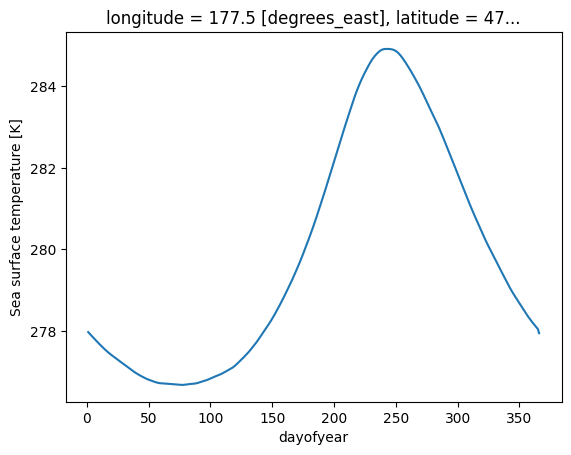

In [6]:
preprocessor.climatology["sst"].isel(latitude=0, longitude=0).plot()

The trend has multiple components, depending on the method. The "linear" method has a slope and an intercept. (Currently, only linear detrending is implemented). 

The example data has already been detrended, so its slope is (basically) 0:

In [7]:
preprocessor.trend["slope"].sst.isel(latitude=0, longitude=0).values

array(9.6901858e-20)

To apply the detrending and climatology removal to a dataset, the `transform` method is used:

In [8]:
preprocessed_data = preprocessor.transform(data)

Text(0.5, 1.0, 'Detrended and climatology removed')

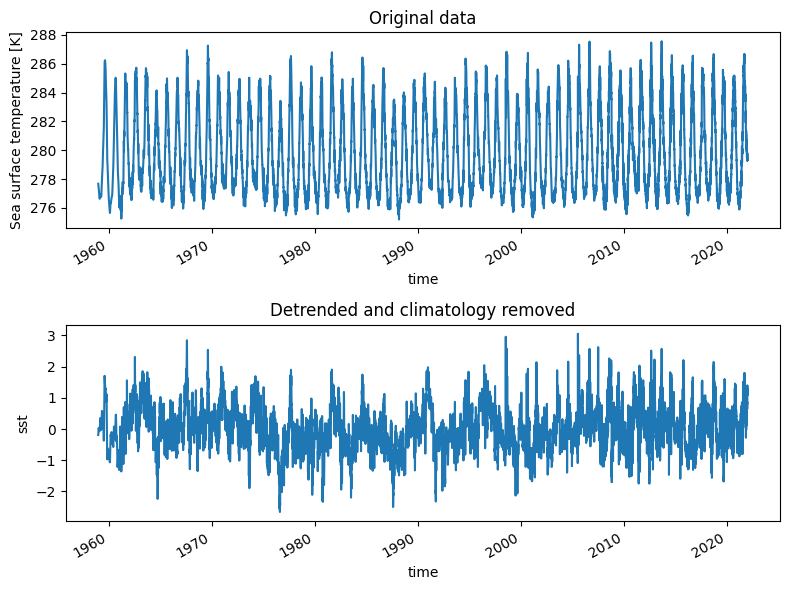

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8, 6))
data.sst.isel(latitude=0, longitude=0).plot(ax=ax1)
preprocessed_data.sst.isel(latitude=0, longitude=0).plot(ax=ax2)
fig.tight_layout()
ax1.set_title("Original data")
ax2.set_title("Detrended and climatology removed")

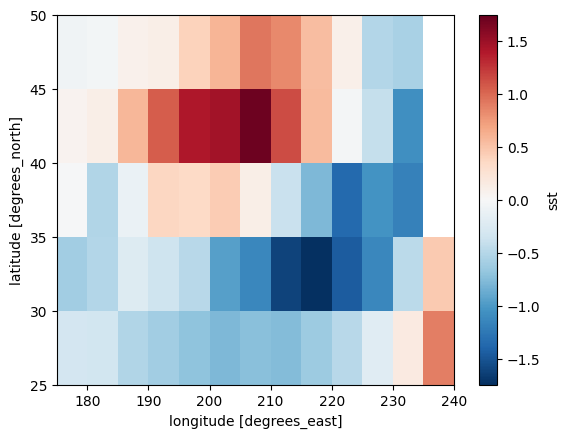

In [10]:
preprocessed_data.sst.sel(time=slice("1980-08-01", "1980-08-31")).mean(dim="time").plot()

`preprocess` module can also work with monthly data and weekly data.

In [11]:
# create monthly data
data_monthly = data.resample(time='M').mean()
data_monthly

<xarray.Dataset>
Dimensions:    (longitude: 13, latitude: 5, time: 756)
Coordinates:
  * longitude  (longitude) float64 177.5 182.5 187.5 192.5 ... 227.5 232.5 237.5
  * latitude   (latitude) float64 47.5 42.5 37.5 32.5 27.5
  * time       (time) datetime64[ns] 1959-01-31 1959-02-28 ... 2021-12-31
Data variables:
    sst        (time, latitude, longitude) float32 277.4 277.6 ... 292.3 292.0
Attributes:
    CDI:          Climate Data Interface version 2.2.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Jun 14 17:26:04 2023: cdo remapbil,/Users/semv/surfdriv...
    CDO:          Climate Data Operators version 2.2.0 (https://mpimet.mpg.de...

In [12]:
preprocessor = preprocess.Preprocessor(
    rolling_window_size=3,
    timescale="monthly",
    detrend="linear",
    subtract_climatology=True,
)

In [13]:
preprocessor.fit(data_monthly)

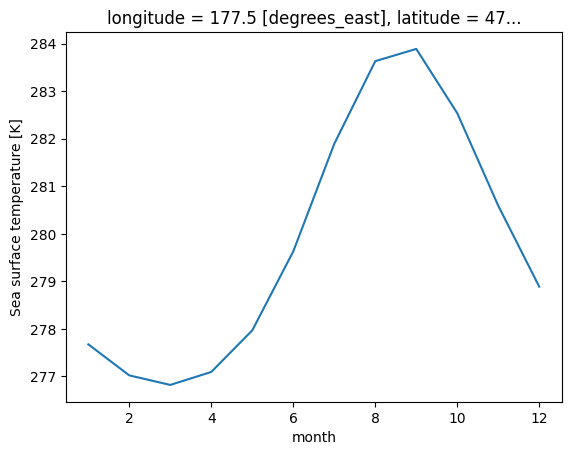

In [14]:
preprocessor.climatology["sst"].isel(latitude=0, longitude=0).plot()

In [15]:
# create weekly data
data_weekly = data.resample(time='W').mean()
data_weekly

<xarray.Dataset>
Dimensions:    (longitude: 13, latitude: 5, time: 3288)
Coordinates:
  * longitude  (longitude) float64 177.5 182.5 187.5 192.5 ... 227.5 232.5 237.5
  * latitude   (latitude) float64 47.5 42.5 37.5 32.5 27.5
  * time       (time) datetime64[ns] 1959-01-04 1959-01-11 ... 2022-01-02
Data variables:
    sst        (time, latitude, longitude) float32 277.7 277.9 ... 291.9 291.5
Attributes:
    CDI:          Climate Data Interface version 2.2.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Jun 14 17:26:04 2023: cdo remapbil,/Users/semv/surfdriv...
    CDO:          Climate Data Operators version 2.2.0 (https://mpimet.mpg.de...

In [16]:
preprocessor = preprocess.Preprocessor(
    rolling_window_size=5,
    timescale="weekly",
    detrend="linear",
    subtract_climatology=True,
)

In [17]:
preprocessor.fit(data_weekly)

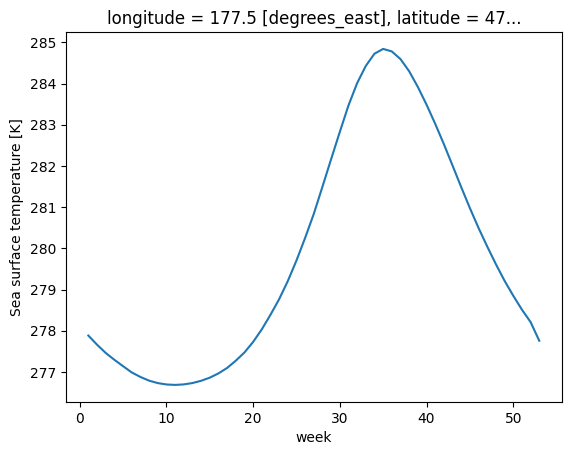

In [18]:
preprocessor.climatology["sst"].isel(latitude=0, longitude=0).plot()